In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.neighbors import NearestNeighbors

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

# Charger les données

In [2]:
movielens_data_dir = "data/ml-1m"  # Dossier qui contient movie.dat et ratings.dat du movieLens dataset.
imdb_dir = "data/imdb"  # Dossier qui contient name.basics.tsv.gz, title.basics.tsv.gz et title.ratings.tsv.gz

In [3]:
def load_data(movielens_data_dir, imdb_dir):
    movies = pd.read_csv(f'{movielens_data_dir}/movies.dat', sep='::', header=None, engine='python',
                         encoding='windows-1252')
    movies.columns = ['movie_id', 'title', 'genres']
    ratings = pd.read_csv(f'{movielens_data_dir}/ratings.dat', sep='::', header=None, engine='python',
                          encoding='windows-1252')
    ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

    name_basics = pd.read_csv(f"{imdb_dir}/name.basics.tsv.gz", sep='\t', na_values='\\N')
    title_basics = pd.read_csv(f"{imdb_dir}/title.basics.tsv.gz", sep='\t', low_memory=False, na_values='\\N')
    title_ratings = pd.read_csv(f"{imdb_dir}/title.ratings.tsv.gz", sep='\t', na_values='\\N')

    return movies, ratings, name_basics, title_basics, title_ratings

In [4]:
datas = load_data(movielens_data_dir, imdb_dir)

# Fusion des datasets

In [5]:
def merge_data_knn(data):
    movies, ratings, name_basics, title_basics, title_ratings = data

    # Extraction de l'année de sorties du film depuis le  titre
    movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(int)
    movies['title_reco'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

    # Fusion des données sur les films entre movieLens et IMDB
    merged_data = pd.merge(movies, title_basics, left_on=['title_reco', 'year'], right_on=['primaryTitle', 'startYear'],
                           how='inner')

    # Ajout des informations sur l'équipe ayant participés à la réalisation des films
    name_basics_ext = name_basics.assign(knownForTitles=name_basics['knownForTitles'].str.split(',')).explode(
        'knownForTitles')
    merged_df = merged_data.merge(name_basics_ext, left_on='tconst', right_on='knownForTitles', how='left')
    result = merged_df.groupby(['movie_id', 'tconst']).agg({
        'primaryName': lambda x: ', '.join(x.dropna().unique())
    }).reset_index()
    merged_data = merged_data.merge(result[['tconst', 'primaryName']], on='tconst', how='left')
    merged_data.rename(columns={'primaryName': 'crew'}, inplace=True)

    # Suppresion des colonnes/lignes qui ne serviront pas dans notre système de recommandation
    merged_data.drop(merged_data[merged_data['titleType'] != 'movie'].index, inplace=True)
    merged_data.drop(
        ['endYear', 'startYear', 'title', 'genres_x', 'titleType', 'primaryTitle', 'originalTitle'],
        axis=1, inplace=True)

    # Nettoyage des données sur le genre et le crew pour créer une liste
    merged_data['crew'] = merged_data['crew'].str.split(',')
    merged_data['genres'] = merged_data['genres_y'].str.split(',')
    merged_data.drop(['genres_y'], axis=1, inplace=True)
    merged_data = merged_data[merged_data['genres'].apply(lambda x: isinstance(x, list))]

    return merged_data

In [6]:
def merge_data_ratings(data):
    movies, ratings, name_basics, title_basics, title_ratings = data

    # Extraction de l'année de sorties du film depuis le  titre
    movies['title_reco'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

    # Fusion des données sur les films entre movieLens et IMDB
    merged_data = pd.merge(movies, title_basics, left_on=['title_reco', 'year'], right_on=['primaryTitle', 'startYear'],
                           how='inner')

    # Ajout des informations de notes
    merged_data = pd.merge(merged_data, ratings, on='movie_id')
    merged_data = pd.merge(merged_data, title_ratings, on='tconst', how='left')
    merged_data.drop('timestamp', axis=1, inplace=True)

    # nettoyage de la note moyenne du film, on met la moyenne si la donnée n'est pas présente
    merged_data['averageRating'] = merged_data['averageRating'].fillna(merged_data['averageRating'].mean())
    merged_data.drop(merged_data[merged_data['titleType'] != 'movie'].index, inplace=True)
    selected_col = ['movie_id', 'title', 'tconst', 'user_id', 'rating', 'averageRating']
    merged_data = merged_data[selected_col]

    return merged_data

# KNN

In [7]:
# On récupère ici les données avec les informations sur les films sans informations sur les notes
datas_knn = merge_data_knn(datas)

In [8]:
# Les genres étant en liste, on rajoute une colonne pour chaque genre, avec '1' si le film est de ce genre, '0' sinon
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(datas_knn['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
datas_knn = datas_knn.join(genres_df)

In [9]:
# Pareil pour les membres de l'équipe d'un film, on regarde que leur nombre car faire pareil que les genres créerait trop de colonnes
datas_knn['crew_size'] = datas_knn['crew'].apply(lambda x: len(x))

In [10]:
numerical_cols = ['year', 'isAdult', 'runtimeMinutes', 'crew_size']
datas_knn[numerical_cols] = datas_knn[numerical_cols].apply(pd.to_numeric)

In [11]:
# On standardise les données choisies
scaler = StandardScaler()
datas_knn[numerical_cols] = scaler.fit_transform(datas_knn[numerical_cols])
datas_knn.fillna(0, inplace=True)

In [12]:
feature_cols = numerical_cols + list(mlb.classes_)

In [ ]:
# Création du modèle de NearestNeighbors en lui donnant les données standardisées
knn = NearestNeighbors(n_neighbors=10, algorithm='auto')
knn.fit(datas_knn[feature_cols])

#### Test du modèle

In [14]:
test = pd.DataFrame(datas_knn[feature_cols].iloc[0].values.reshape(1, -1))
test.columns = datas_knn[feature_cols].columns

In [15]:
distances, indices = knn.kneighbors(test, n_neighbors=5)

In [83]:
print(f"Les 5 films les plus proches de '{datas_knn['title_reco'].iloc[0]}' sont:")
for indice, distance in zip(indices[0], distances[0]):
    print(f"- {datas_knn['title_reco'].iloc[indice]} : {distance}")

Les 5 films les plus proches de 'Toy Story' sont:
- Toy Story : 0.0
- Agnes Browne : 0.630246791997006
- Matilda : 1.0678151066348183
- Sirens : 1.1144350174081197
- Teaching Mrs. Tingle : 1.173780202266724


# Filtrage collaboratif

In [17]:
collab_datas = merge_data_ratings(datas)

In [18]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(collab_datas[['user_id', 'movie_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

model_collaborative = SVD()

In [19]:
model_collaborative.fit(trainset)

### Test du modèle

In [24]:
predictions = model_collaborative.test(testset)

rmse = accuracy.rmse(predictions)

RMSE: 0.8788


# Système de recommandation

## Modèle pour le couple

In [89]:
def hybrid_recommendations(user1_id, user2_id, top_n=10, w1=0.5, w2=0.5):
    # Liste des films vus par chaque utilisateur
    user1_seen = collab_datas[collab_datas['user_id'] == user1_id]['movie_id'].unique()
    user2_seen = collab_datas[collab_datas['user_id'] == user2_id]['movie_id'].unique()

    # Films non vus par les deux utilisateurs
    all_movies = collab_datas['movie_id'].unique()
    unseen_movies = set(all_movies) - set(user1_seen) - set(user2_seen)

    # KNN
    content_recommendations = []
    for movie_id in unseen_movies:
        to_pred = pd.DataFrame(datas_knn[feature_cols].loc[datas_knn['movie_id'] == movie_id][feature_cols].iloc[0].values.reshape(1, -1))
        to_pred.columns = datas_knn[feature_cols].columns
        distances, indices = knn.kneighbors(to_pred, n_neighbors= top_n)
        avg_content_score = sum(1 - distances.flatten()) / len(distances.flatten())
        content_recommendations.append((movie_id, avg_content_score))

    # SVD
    collaborative_recommendations = []
    for movie_id in unseen_movies:
        pred_user1 = model_collaborative.predict(user1_id, movie_id).est
        pred_user2 = model_collaborative.predict(user2_id, movie_id).est
        avg_collaborative_score = (pred_user1 + pred_user2) / 2
        collaborative_recommendations.append((movie_id, avg_collaborative_score))

    # Combinaison des scores
    hybrid_scores = []
    for movie_id in unseen_movies:
        content_score = next((score for mid, score in content_recommendations if mid == movie_id), 0)
        collaborative_score = next((score for mid, score in collaborative_recommendations if mid == movie_id), 0)
        hybrid_score = w1 * content_score + w2 * collaborative_score
        hybrid_scores.append((movie_id, hybrid_score))

    # Trier les films par score hybride
    hybrid_scores.sort(key=lambda x: x[1], reverse=True)

    recommended_movies = [(datas_knn[datas_knn['movie_id'] == movie_id]['title_reco'].values[0], score) for movie_id, score in hybrid_scores[:top_n]]

    return recommended_movies

### Test du modèle

In [90]:
user1_id = 1
user2_id = 2
recommendations = hybrid_recommendations(user1_id, user2_id)

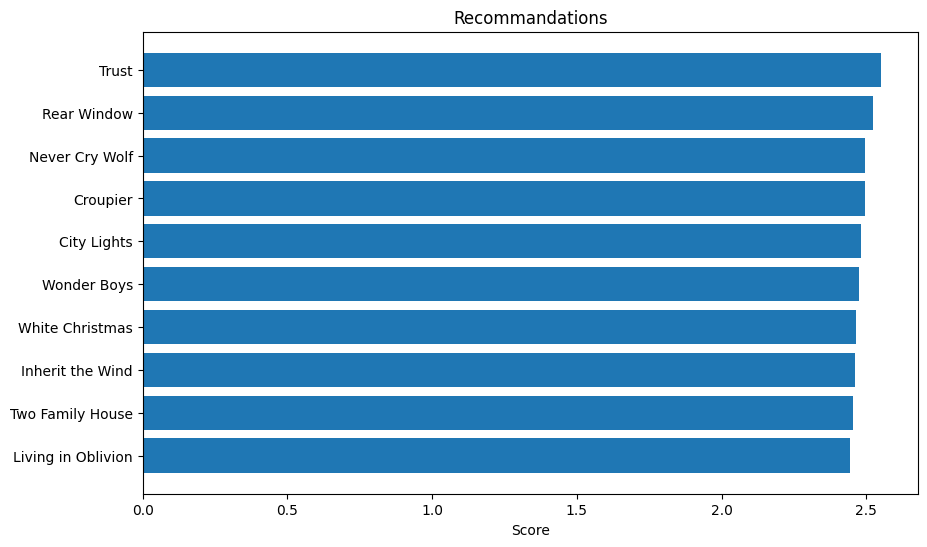

In [92]:
titles = [movie[0] for movie in recommendations]
scores = [movie[1] for movie in recommendations]

plt.figure(figsize=(10, 6))
plt.barh(titles, scores)
plt.xlabel('Score')
plt.title('Recommandations')
plt.gca().invert_yaxis()
plt.show()

In [87]:
user1_id = 289
user2_id = 24
recommendations = hybrid_recommendations(user1_id, user2_id)

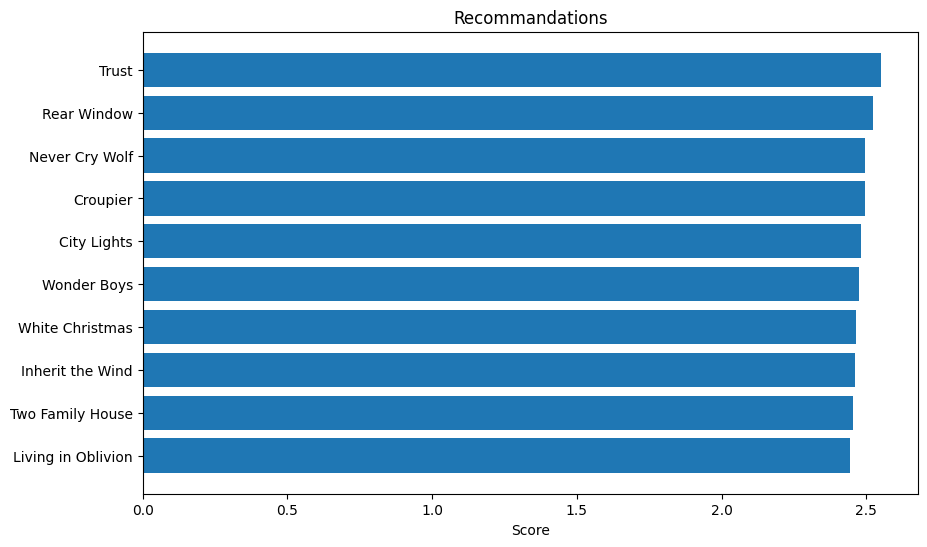

In [93]:
titles = [movie[0] for movie in recommendations]
scores = [movie[1] for movie in recommendations]

plt.figure(figsize=(10, 6))
plt.barh(titles, scores)
plt.xlabel('Score')
plt.title('Recommandations')
plt.gca().invert_yaxis()
plt.show()